In [1]:
import warnings
warnings.filterwarnings('ignore')
# import cv2

from keras.models import load_model
import tensorflow as tf
from keras import optimizers
import keras
import segmentation_models as sm

from commons import *
import metric
from architecture import create_model, create_callbacks


BACKUP_MODEL_PATH = "./../Models/backup.h5"
BACKUP_HISTORY_PATH = "./../Models/backup.csv"
seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = 4

ROOT = "./../Data/all-cities/"
TRAIN_DIR = "_Train512/"
BACKBONE = 'densenet121'
USE_AUGMENTATION = True

# 'efficientnetb2'
# 'inceptionv3'
# 'densenet121'
# 'resnet34'
# 'vgg16'

Segmentation Models: using `keras` framework.


In [2]:
train_gen, val_gen = train_val_generator(IMAGE_WIDTH, IMAGE_HEIGHT, ROOT, TRAIN_DIR, BATCH_SIZE, seed,
                                         use_aug=USE_AUGMENTATION)

Found 8410 files belonging to 1 classes.
Using 7738 files for training.
Found 8410 files belonging to 1 classes.
Using 672 files for validation.
Found 8410 files belonging to 1 classes.
Using 7738 files for training.
Found 8410 files belonging to 1 classes.
Using 672 files for validation.


In [3]:
"""Load Model backup to resume training after crash or break or for pretraining"""
model = load_model(BACKUP_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.5), "f1-score":sm.metrics.FScore(), "quality":metric.quality()})
model.compile(optimizer=model.optimizer, loss=model.loss, metrics= model.metrics[1:], run_eagerly=True)
callbacks = create_callbacks(BACKUP_MODEL_PATH, BACKUP_HISTORY_PATH)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['input_2[0][0]']                
 2D)                            3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_34[0][0]']      
                                64)                                                         

Epoch 24/100
1935/1935 [==============================] - ETA: 0s - loss: 0.5348 - iou_score: 0.3126 - f1-score: 0.4652 - quality: 0.6154
Epoch 24: val_loss improved from inf to 0.52757, saving model to ./../Models\backup.h5
1935/1935 [==============================] - 1191s 612ms/step - loss: 0.5348 - iou_score: 0.3126 - f1-score: 0.4652 - quality: 0.6154 - val_loss: 0.5276 - val_iou_score: 0.3203 - val_f1-score: 0.4724 - val_quality: 0.6277 - lr: 1.0000e-05
Epoch 25/100
1935/1935 [==============================] - ETA: 0s - loss: 0.5348 - iou_score: 0.3130 - f1-score: 0.4652 - quality: 0.6175
Epoch 25: val_loss improved from 0.52757 to 0.52693, saving model to ./../Models\backup.h5
1935/1935 [==============================] - 1187s 613ms/step - loss: 0.5348 - iou_score: 0.3130 - f1-score: 0.4652 - quality: 0.6175 - val_loss: 0.5269 - val_iou_score: 0.3188 - val_f1-score: 0.4731 - val_quality: 0.6325 - lr: 1.0000e-05
Epoch 26/100
1935/1935 [==============================] - ETA: 0s - 

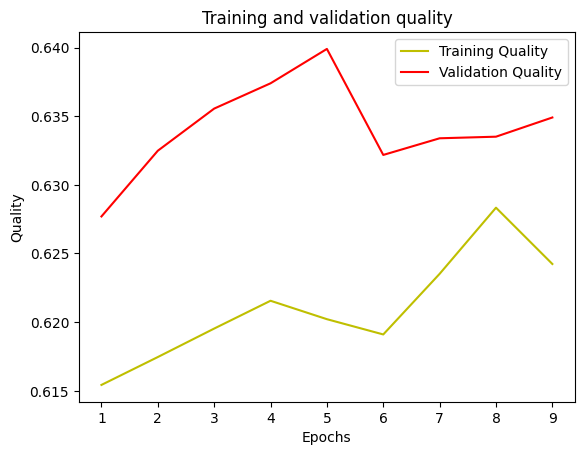

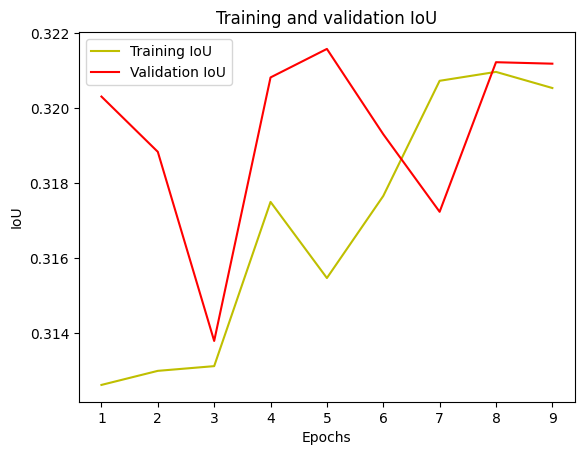

In [4]:
history = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=EPOCHS, verbose=1, initial_epoch=23) #,

model_path = f"./../Models/color-aug/dbunet.h5"
save_model(model, model_path=model_path, csv_history_path_to_delete=BACKUP_HISTORY_PATH)
plot_history(model.history, model_path)

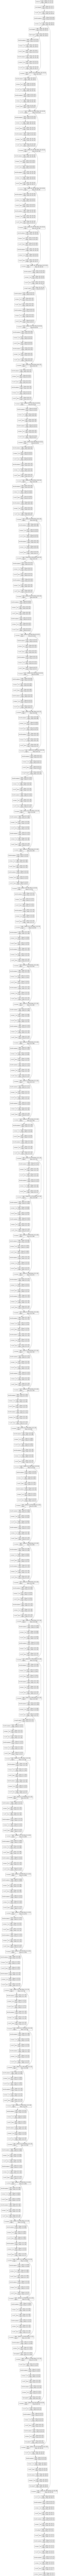

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='./../Models/unet_struct.png',show_shapes=True, show_layer_activations=True, show_layer_names=False)

from IPython.display import Image as IP_Image
IP_Image(retina=True, filename='./../Models/unet_struct.png')

In [8]:
# define model
model = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', encoder_freeze=True )

opt = keras.optimizers.Adam(LEARNING_RATE)
callbacks = create_callbacks(BACKUP_MODEL_PATH, BACKUP_HISTORY_PATH)

model.compile(
    optimizer=opt,
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_36 (ZeroPadding  (None, 518, 518, 3)  0          ['input_2[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d_36[0][0]']      
                                )                                                           

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

history1 = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=12, verbose=1) #,

for layer in model.layers:
    layer.trainable = True

opt = model.optimizer
opt.lr = LEARNING_RATE / 10

model.compile(
    optimizer=opt,
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
)

history = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=EPOCHS, verbose=1) #,

keys = ['quality', 'iou_score', 'val_iou_score', 'val_quality']
for key in keys:
    history.history[key] = history1.history[key] + history.history[key]


Num GPUs Available:  1
Epoch 1/12
  32/1934 [..............................] - ETA: 20:50 - loss: 0.9379 - iou_score: 0.0302 - f1-score: 0.0621 - quality: 0.1087

KeyboardInterrupt: 

In [5]:
model_path = "./../Models/Binary/512/backbones/bike_mapper_pre-train-scratch-densenet121_Train3607_Val313_Test980_No-Aug.h5"
save_model(model, model_path=model_path, csv_history_path_to_delete=BACKUP_HISTORY_PATH)
plot_history(history, model_path)

Time of saving model: 2022-10-28 21:01:15.664278


Found 8410 files belonging to 1 classes.
Using 7738 files for training.
Found 8410 files belonging to 1 classes.
Using 672 files for validation.
Found 8410 files belonging to 1 classes.
Using 7738 files for training.
Found 8410 files belonging to 1 classes.
Using 672 files for validation.
Epoch 1/6
1935/1935 [==============================] - ETA: 0s - loss: 0.7664 - iou_score: 0.1357 - f1-score: 0.2337 - quality: 0.3369
Epoch 1: val_loss improved from inf to 0.70966, saving model to ./../Models\backup.h5
1935/1935 [==============================] - 1083s 555ms/step - loss: 0.7664 - iou_score: 0.1357 - f1-score: 0.2337 - quality: 0.3369 - val_loss: 0.7097 - val_iou_score: 0.1734 - val_f1-score: 0.2903 - val_quality: 0.4119 - lr: 0.0010
Epoch 2/6
1935/1935 [==============================] - ETA: 0s - loss: 0.7100 - iou_score: 0.1733 - f1-score: 0.2901 - quality: 0.4027
Epoch 2: val_loss improved from 0.70966 to 0.68220, saving model to ./../Models\backup.h5
1935/1935 [==================

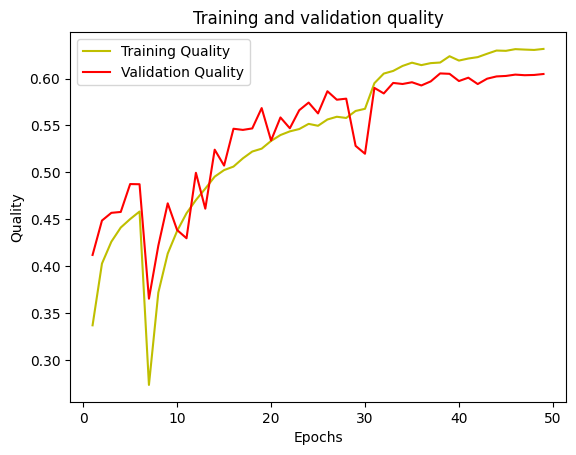

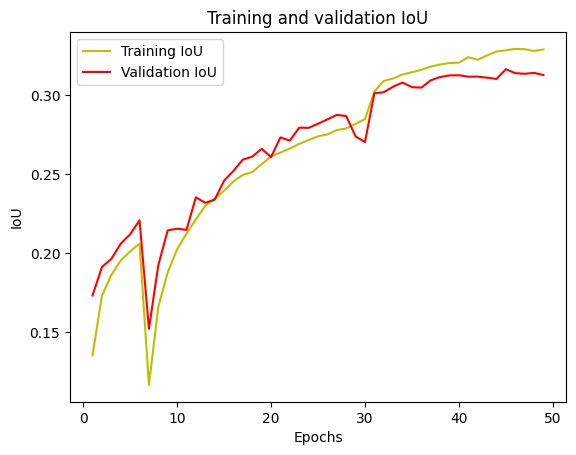

Found 8410 files belonging to 1 classes.
Using 7738 files for training.
Found 8410 files belonging to 1 classes.
Using 672 files for validation.
Found 8410 files belonging to 1 classes.
Using 7738 files for training.
Found 8410 files belonging to 1 classes.
Using 672 files for validation.
Epoch 1/6
1935/1935 [==============================] - ETA: 0s - loss: 0.7642 - iou_score: 0.1366 - f1-score: 0.2358 - quality: 0.3450
Epoch 1: val_loss improved from inf to 0.78582, saving model to ./../Models\backup.h5
1935/1935 [==============================] - 730s 376ms/step - loss: 0.7642 - iou_score: 0.1366 - f1-score: 0.2358 - quality: 0.3450 - val_loss: 0.7858 - val_iou_score: 0.1170 - val_f1-score: 0.2142 - val_quality: 0.3650 - lr: 0.0010
Epoch 2/6
1935/1935 [==============================] - ETA: 0s - loss: 0.7124 - iou_score: 0.1716 - f1-score: 0.2876 - quality: 0.4094
Epoch 2: val_loss did not improve from 0.78582
1935/1935 [==============================] - 725s 374ms/step - loss: 0.71

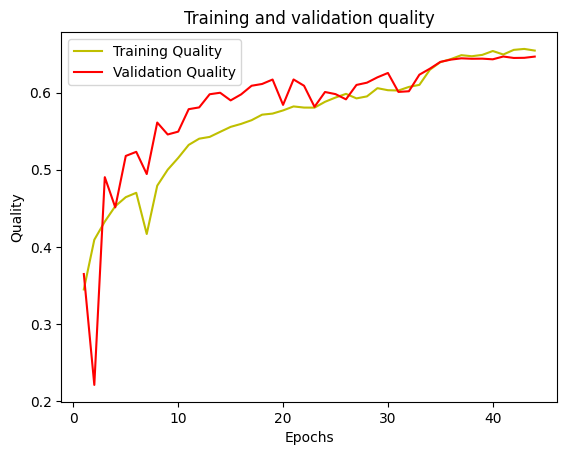

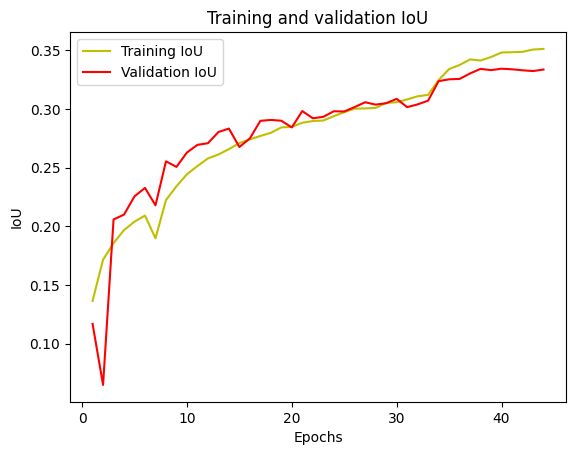

Found 8410 files belonging to 1 classes.
Using 7738 files for training.
Found 8410 files belonging to 1 classes.
Using 672 files for validation.
Found 8410 files belonging to 1 classes.
Using 7738 files for training.
Found 8410 files belonging to 1 classes.
Using 672 files for validation.
Epoch 1/6
1935/1935 [==============================] - ETA: 0s - loss: 0.7357 - iou_score: 0.1559 - f1-score: 0.2643 - quality: 0.3822
Epoch 1: val_loss improved from inf to 0.67747, saving model to ./../Models\backup.h5
1935/1935 [==============================] - 1094s 564ms/step - loss: 0.7357 - iou_score: 0.1559 - f1-score: 0.2643 - quality: 0.3822 - val_loss: 0.6775 - val_iou_score: 0.1958 - val_f1-score: 0.3225 - val_quality: 0.4649 - lr: 0.0010
Epoch 2/6
1935/1935 [==============================] - ETA: 0s - loss: 0.6883 - iou_score: 0.1889 - f1-score: 0.3117 - quality: 0.4380
Epoch 2: val_loss improved from 0.67747 to 0.65467, saving model to ./../Models\backup.h5
1935/1935 [==================

In [ ]:
# 'inceptionv3'
# 'densenet121'
# 'resnet34'
# 'vgg16'
# 'efficientnetb2'

backbones = [('vbunet-s', 'vgg16'), ('rbunet-s', 'resnet34'), ('dbunet-s', 'densenet121')]

for label, b in backbones:
    BACKBONE = b

    train_gen, val_gen = train_val_generator(IMAGE_WIDTH, IMAGE_HEIGHT, ROOT, TRAIN_DIR, BATCH_SIZE, seed,
                                         use_aug=USE_AUGMENTATION)

    # define model
    model: keras.Model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True )

    opt = keras.optimizers.Adam(LEARNING_RATE)
    callbacks = create_callbacks(BACKUP_MODEL_PATH, BACKUP_HISTORY_PATH)

    model.compile(
        optimizer=opt,
        loss=sm.losses.DiceLoss(),
        metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
    )

    history1 = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=6, verbose=1) #,

    for layer in model.layers:
        layer.trainable = True

    opt = model.optimizer
    opt.lr = LEARNING_RATE / 10

    model.compile(
        optimizer=opt,
        loss=sm.losses.DiceLoss(),
        metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
    )

    history = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=EPOCHS, verbose=1, initial_epoch=6) #,

    keys = ['quality', 'iou_score', 'val_iou_score', 'val_quality']
    for key in keys:
        history.history[key] = history1.history[key] + history.history[key]

    model_path = f"./../Models/color-aug/{label}.h5"
    save_model(model, model_path=model_path, csv_history_path_to_delete=BACKUP_HISTORY_PATH)
    plot_history(history, model_path)


In [ ]:
import os
os.system("shutdown /s /t 1")